In [1]:
# Vision Transformer Fullsight: Experiment, das die Transformer Netze, die jeden Pixel als Token nehmen,
# nachbilden soll. Allerdings werden nicht die Pixel untereinander Attention haben, sondern wie beim
# Transformer Paper (ISAB-Layer) wird ein kleiner Latent Space dazwischen geschaltet

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import pickle as pkl

%load_ext autoreload
%autoreload 2
from utils import *
from layers import *
from transformer import *
from cifar10 import *

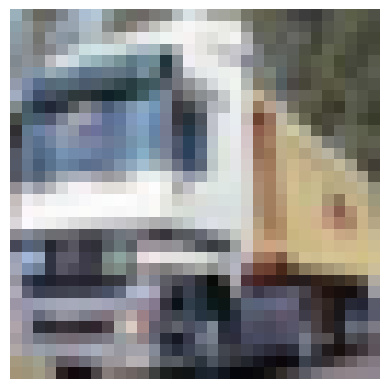

In [2]:
showimg(getimg(1))
getlabel(1)

showimg(getimg(1))

In [3]:

def batchgen(bsize=64, start=500):
    ep = 0
    while True:
        inds = np.random.permutation(range(start, N))
        minibatches = [ inds[k*bsize:(k+1)*bsize] for k in range(len(inds)//bsize) ]
        for mb in minibatches:
            xs = []
            ys = []
            for i in mb:
                xs.append(getimg(i))
                ys.append(getlabel(i))
            yield np.array(xs), np.array(ys)
        print(f'========== EPOCH {ep} COMPLETED ==========')
        ep += 1

In [5]:
bg = batchgen()
xs, ys = next(bg)
xs.shape

(64, 32, 32, 3)

In [16]:
from layers import *

class Net(nn.Module):
    
    def __init__(self, n, nh, M):
        super().__init__()
        self.dense1 = nn.Linear(3, n)
        self.posenc2d = PositionalEncoding2d(n)
        self.ln1 = LayerNorm(n)
        self.seed = Seed(n, M)
        self.isab1 = ISAB2(n, n, nh)
        self.isab2 = ISAB2(n, n, nh)
        self.isab3 = ISAB2(n, n, nh)
        #self.isab4 = ISAB2(n, n, nh)
        #self.isab5 = ISAB2(n, n, nh)
        #self.isab6 = ISAB2(n, n, nh)
        self.ln2 = LayerNorm(n)
        self.dense2 = nn.Linear(n, 10)
        self.cuda()
    
    def forward(self, x):
        x = self.dense1(x)
        x = x / np.sqrt(x.shape[2])
        x = self.posenc2d(x)
        x = rearrange(x, 'b h w c -> b (h w) c')
        x = self.ln1(x)
        y = self.seed(x)
        x, y = self.isab1(x, y)
        x, y = self.isab2(x, y)
        x, y = self.isab3(x, y)
        #x, y = self.isab4(x, y)
        #x, y = self.isab5(x, y)
        #x, y = self.isab6(x, y)
        y = self.ln2(y)
        y = y[:,0,:]
        y = self.dense2(y)
        return y

In [17]:
net = Net(128, 4, 10)
from torch_optimizer import Lookahead, Yogi
net.optim = Lookahead(Yogi(net.parameters(), lr=3e-3))
net.iters = 0
net.losses = []
net.vlosses = []
net.slosses = []
net.vaccs = []
bg = batchgen()

from torchsummary import summary
summary(net, (32, 32, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1          [-1, 32, 32, 128]             512
PositionalEncoding2d-2          [-1, 32, 32, 128]               0
         LayerNorm-3            [-1, 1024, 128]               0
            Linear-4              [-1, 10, 128]           1,280
              Seed-5              [-1, 10, 128]               0
         LayerNorm-6              [-1, 10, 128]               0
            Linear-7              [-1, 10, 128]          16,512
            Linear-8            [-1, 1024, 128]          16,512
            Linear-9            [-1, 1024, 128]          16,512
           Linear-10              [-1, 10, 128]          16,512
MultiHeadAttention-11              [-1, 10, 128]               0
        LayerNorm-12              [-1, 10, 128]               0
           Linear-13              [-1, 10, 512]          66,048
           Linear-14              [-

In [19]:
def valloss():
    net.eval()
    xs = np.array([getimg(i) for i in range(200)])
    yt = np.array([getlabel(i) for i in range(200)])
    xs, yt = np2t(xs, yt)
    yt = yt.long()
    yp = net(xs)
    loss = F.nll_loss(F.log_softmax(yp, dim=1), yt).item()
    yp, yt = t2np(yp, yt)
    yp = yp.argmax(-1)
    acc = np.mean(yp==yt)
    return loss, acc
    
def loss():
    net.train()
    xs, yt = next(bg)
    xs, yt = np2t(xs, yt)
    yt = yt.long()
    yp = net(xs)
    return F.nll_loss(F.log_softmax(yp, dim=1), yt)

loss()

tensor(2.4129, device='cuda:0', grad_fn=<NllLossBackward0>)

  0%|          | 0/999999 [00:00<?, ?it/s]

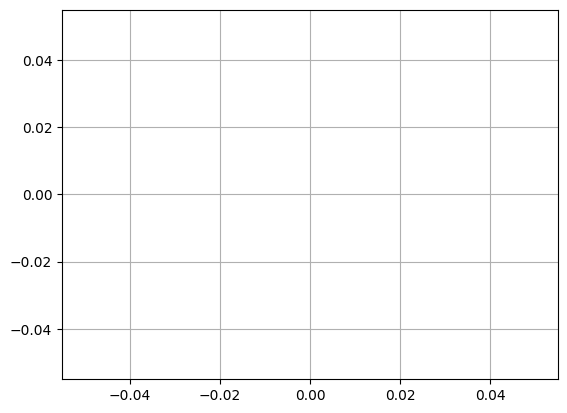

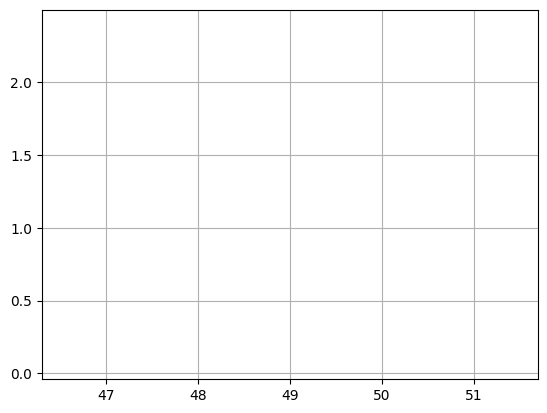

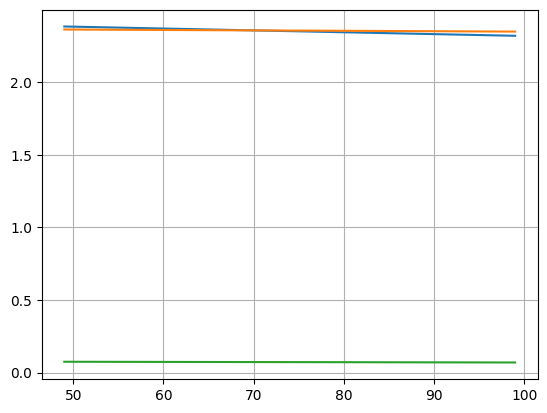

========== EPOCH 0 COMPLETED ==========


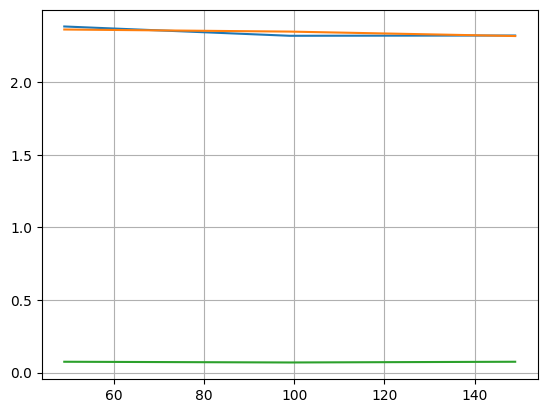

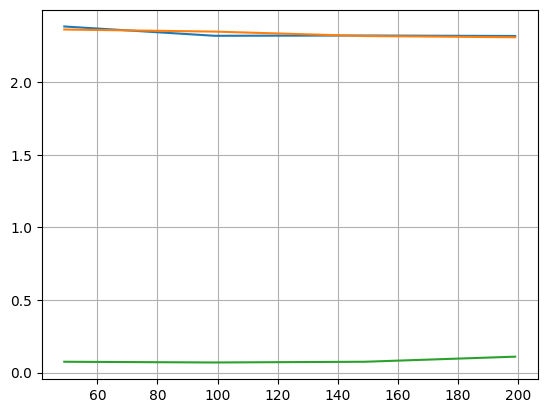

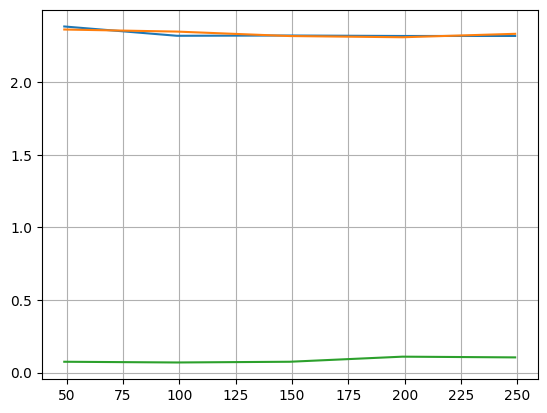

========== EPOCH 1 COMPLETED ==========


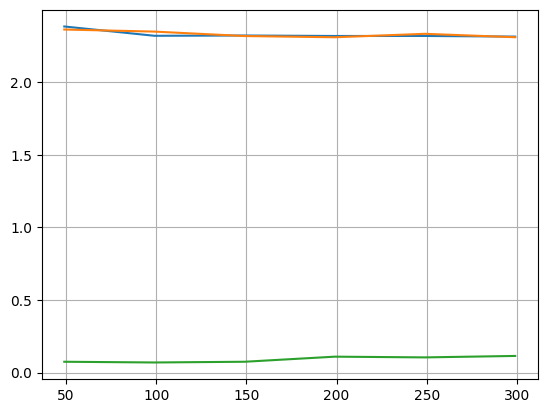

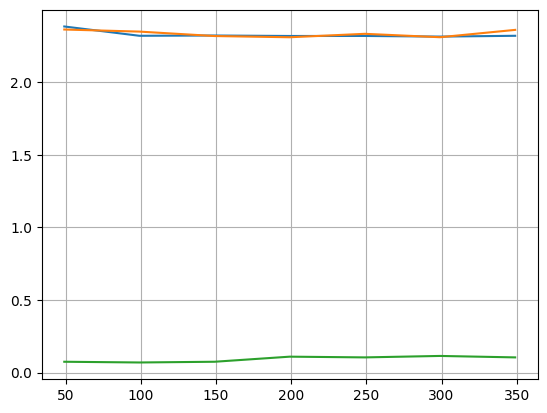

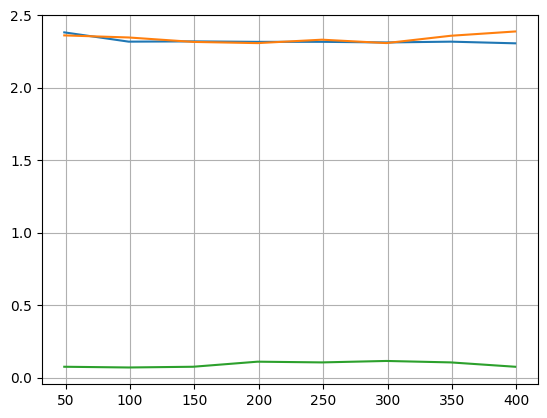

========== EPOCH 2 COMPLETED ==========


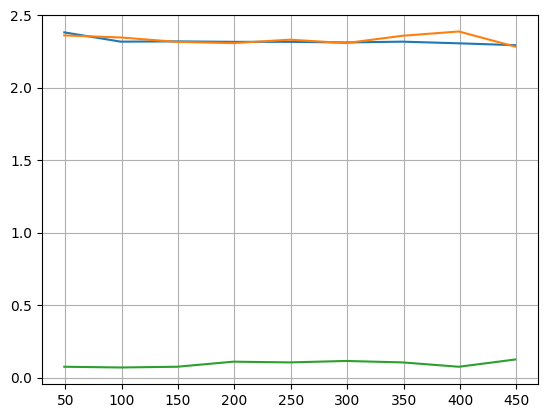

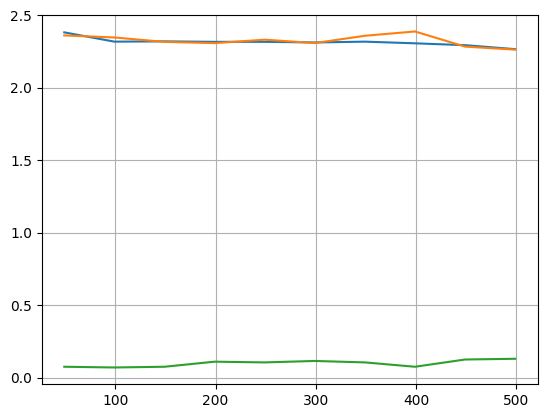

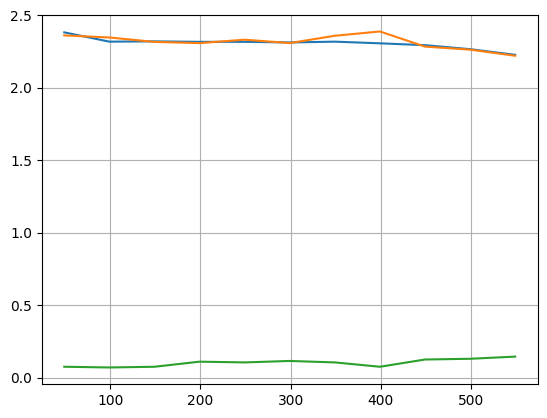

========== EPOCH 3 COMPLETED ==========


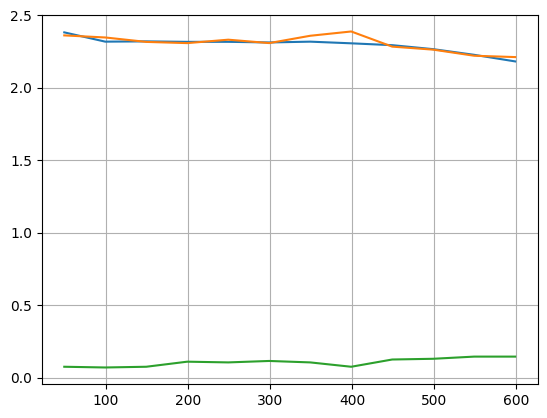

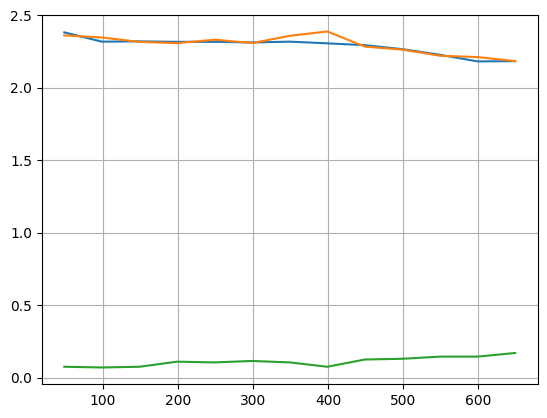

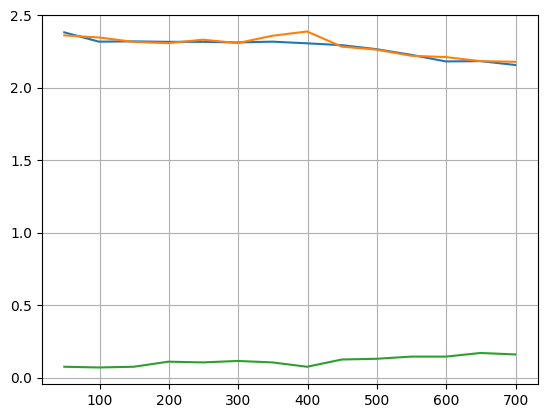

========== EPOCH 4 COMPLETED ==========


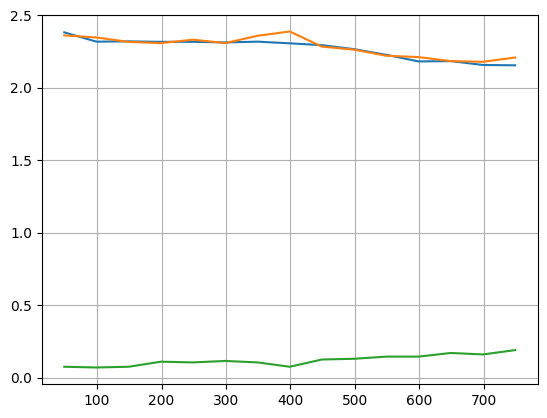

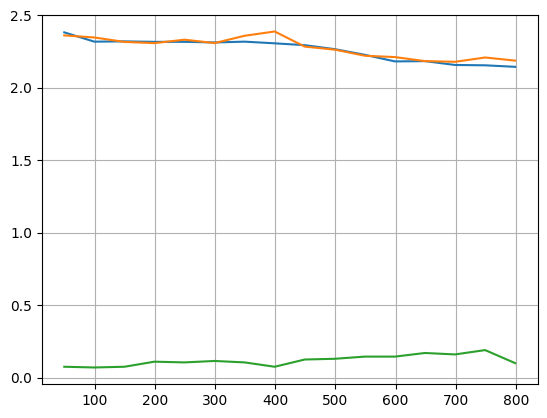

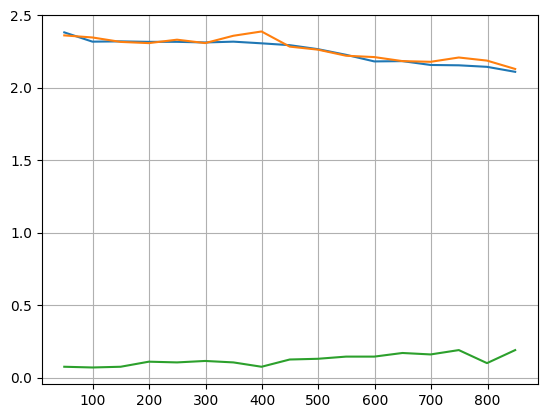

========== EPOCH 5 COMPLETED ==========


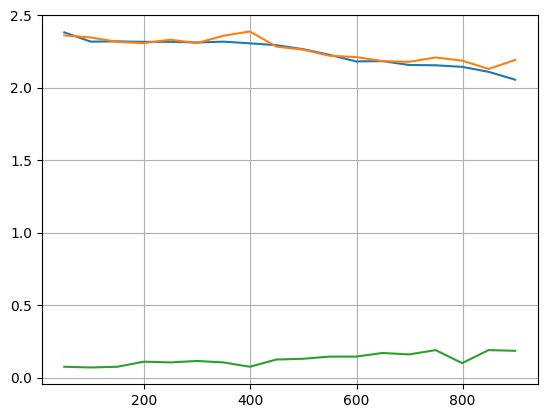

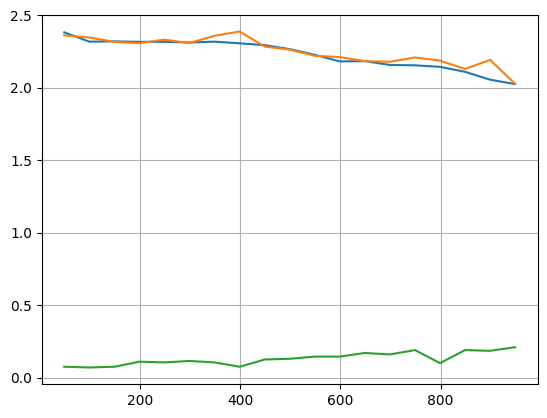

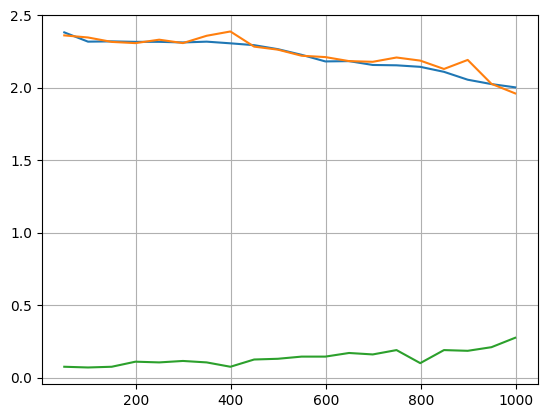

========== EPOCH 6 COMPLETED ==========


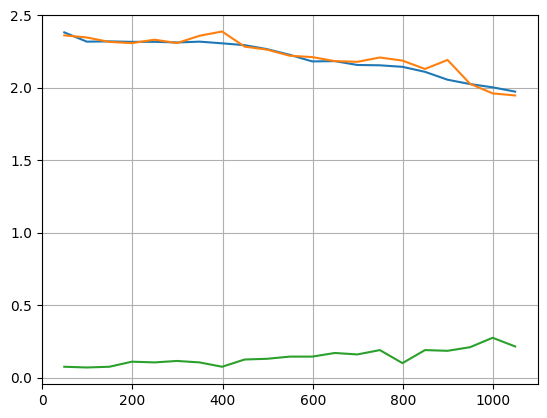

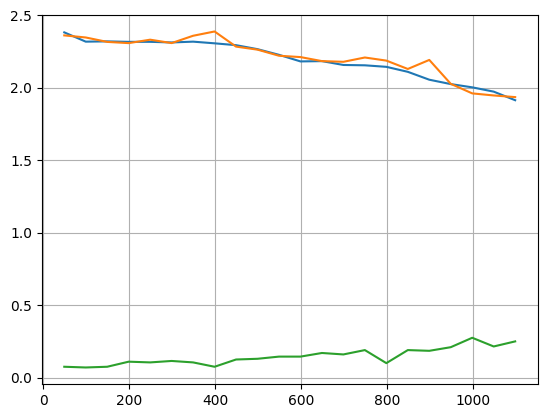

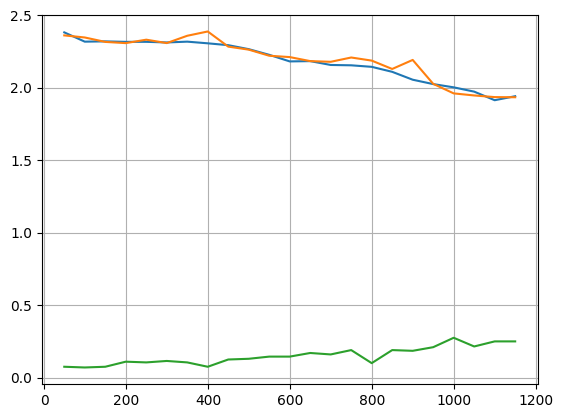

========== EPOCH 7 COMPLETED ==========


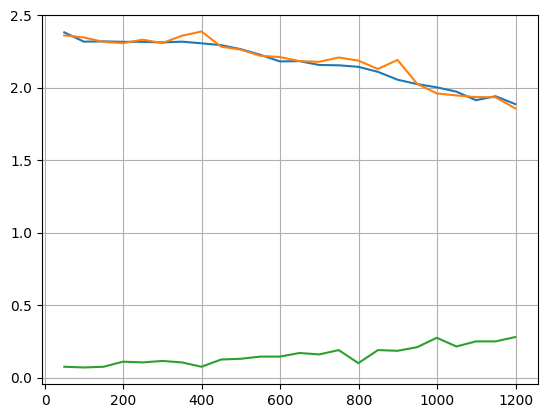

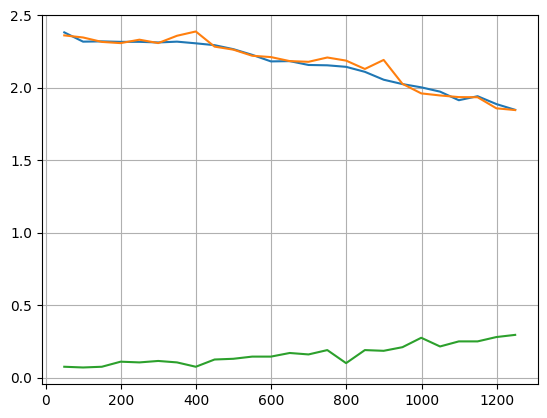

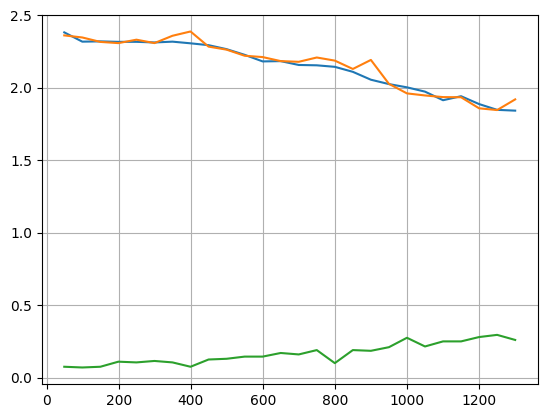

========== EPOCH 8 COMPLETED ==========


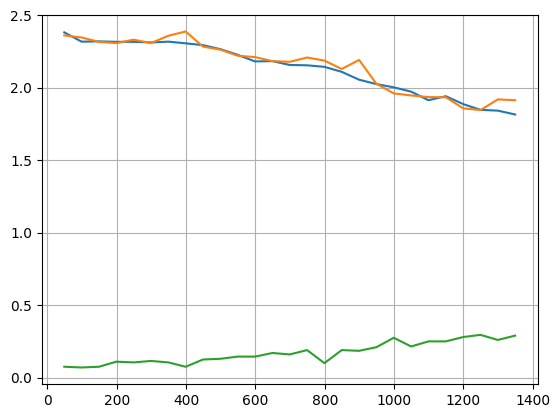

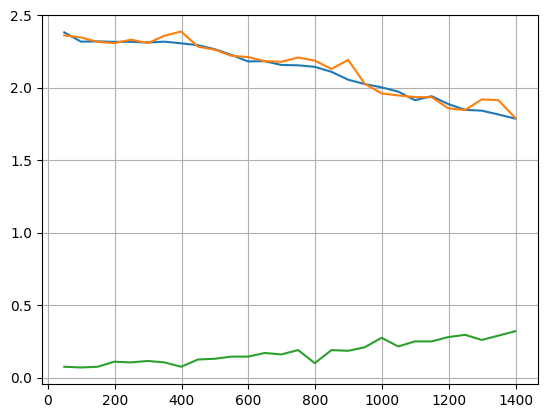

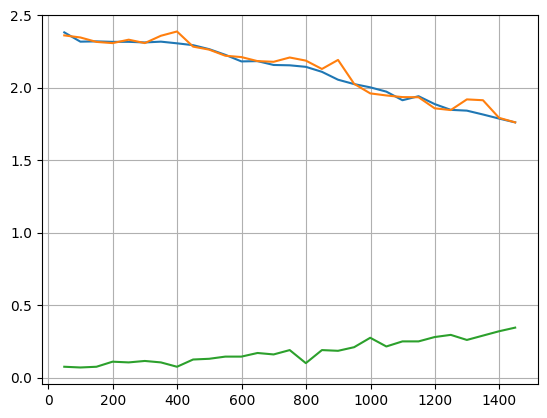

========== EPOCH 9 COMPLETED ==========


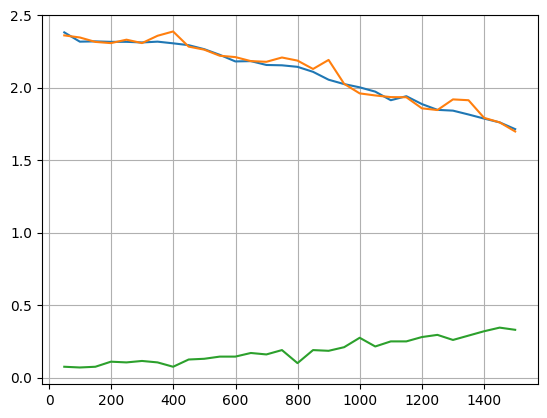

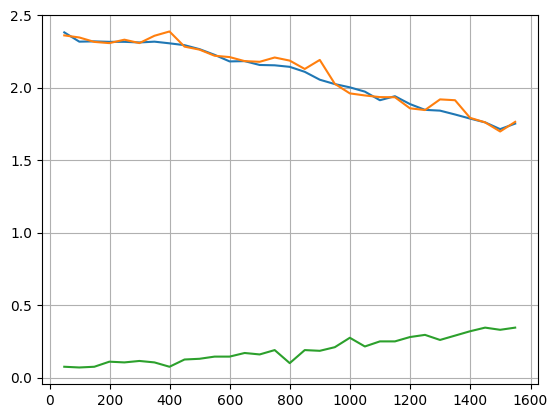

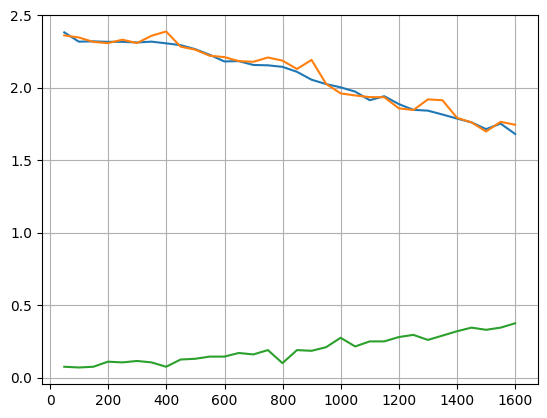

========== EPOCH 10 COMPLETED ==========


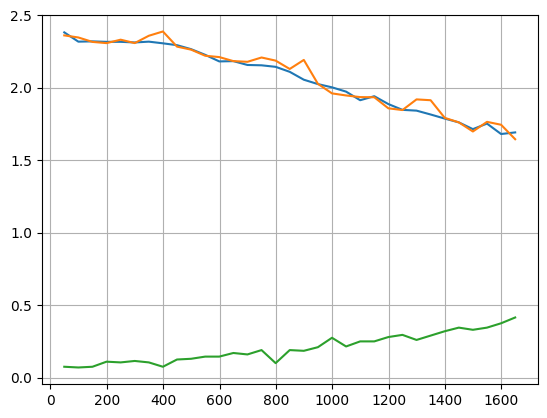

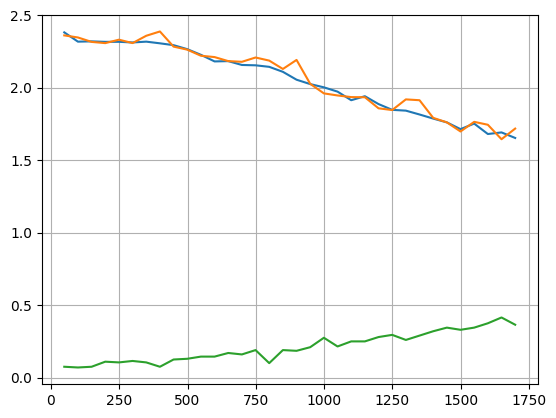

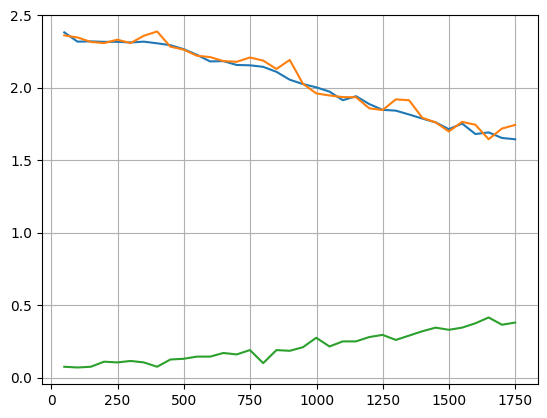

========== EPOCH 11 COMPLETED ==========


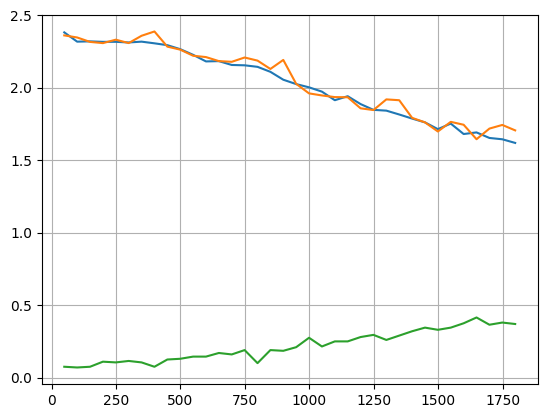

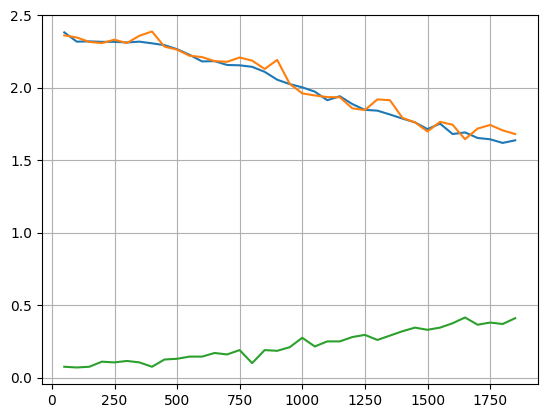

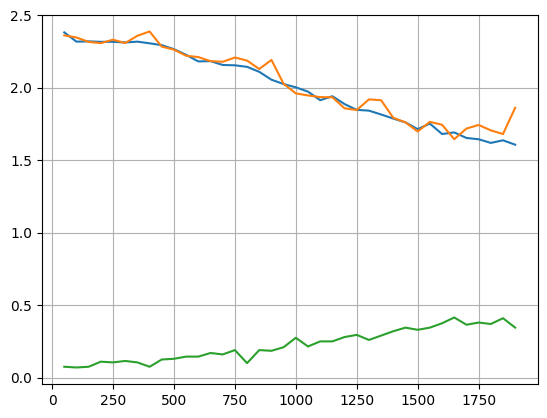

========== EPOCH 12 COMPLETED ==========


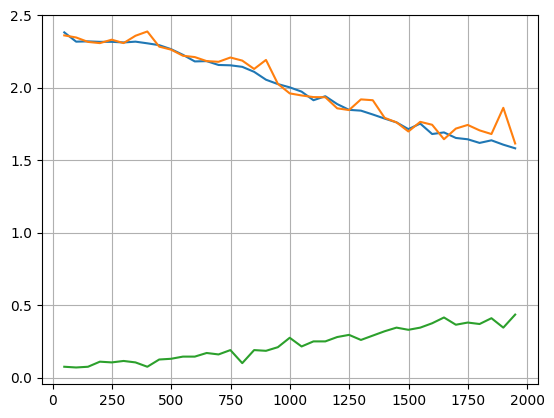

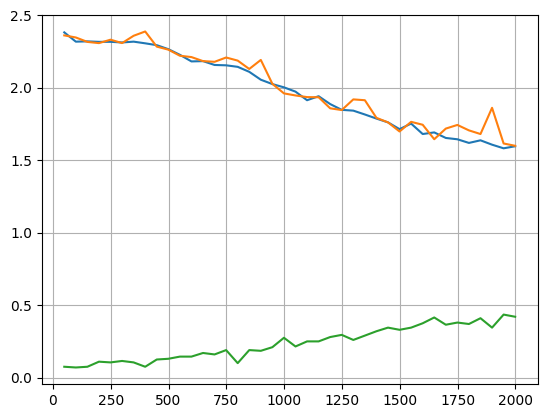

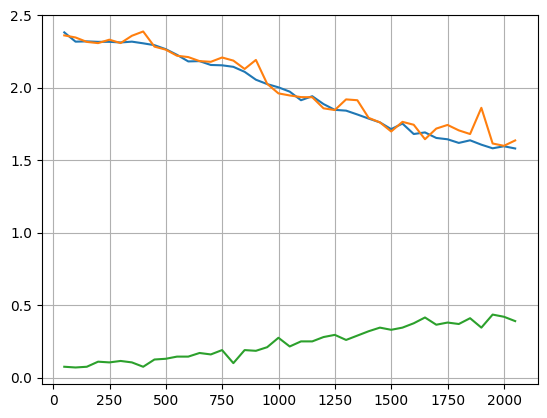

========== EPOCH 13 COMPLETED ==========


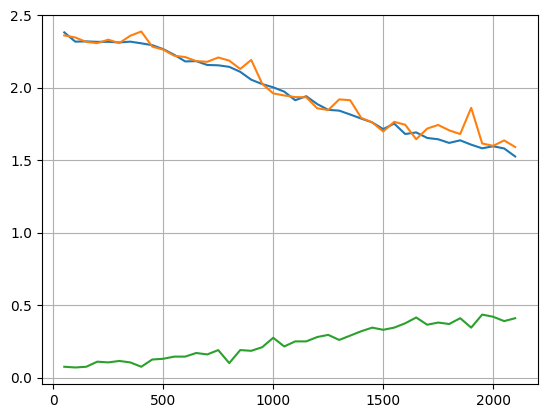

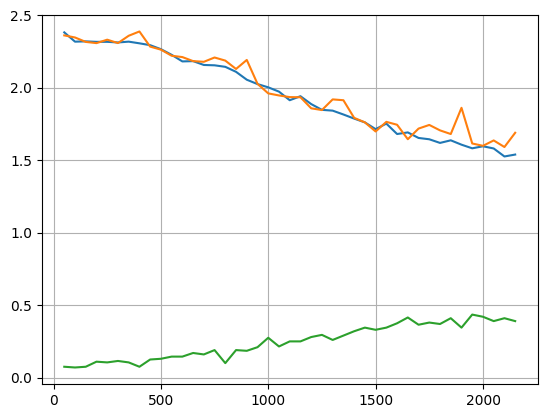

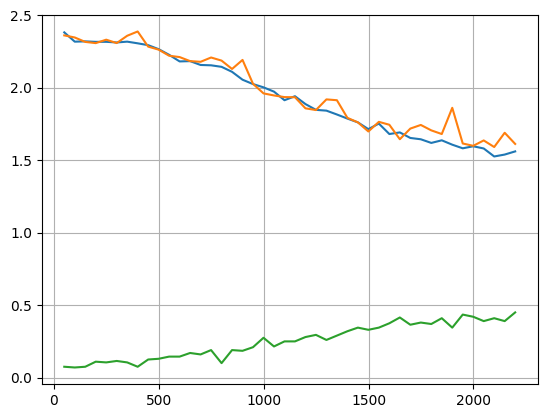

========== EPOCH 14 COMPLETED ==========


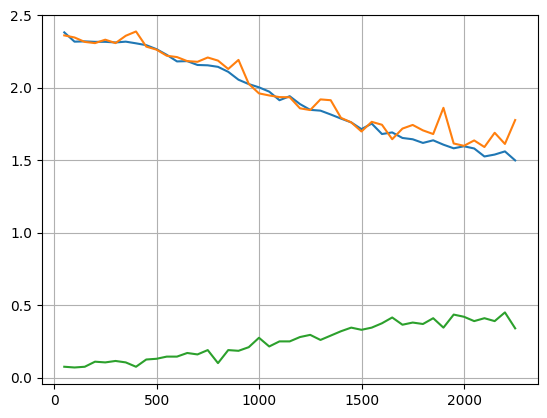

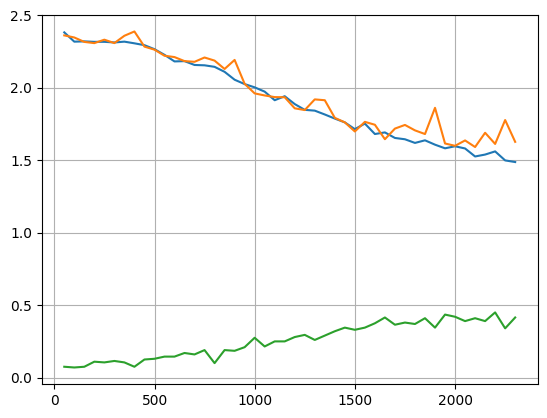

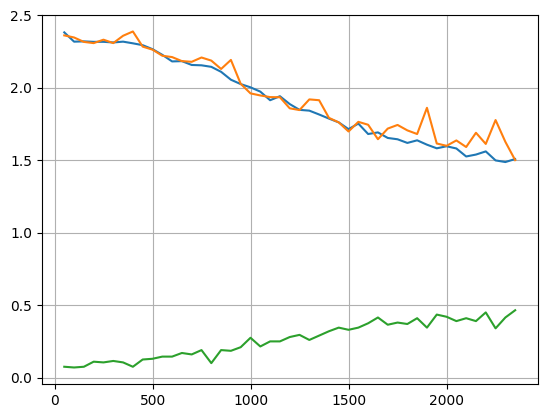

========== EPOCH 15 COMPLETED ==========


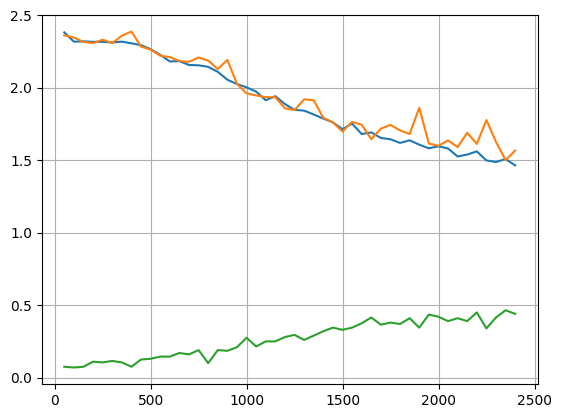

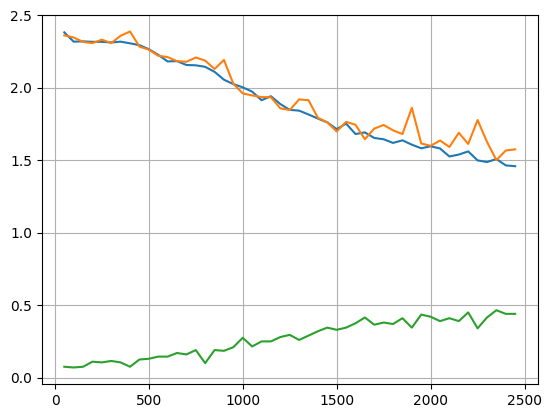

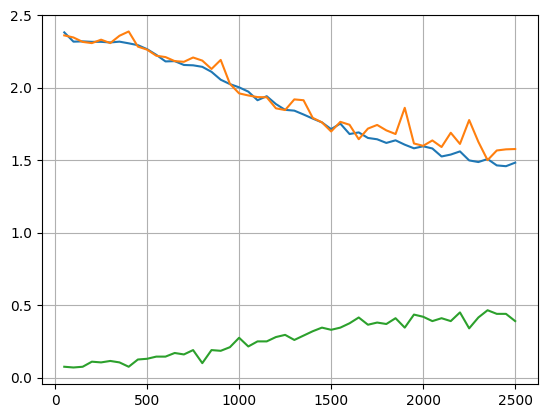

========== EPOCH 16 COMPLETED ==========


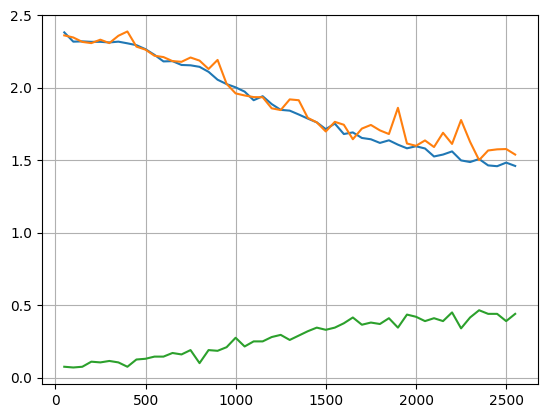

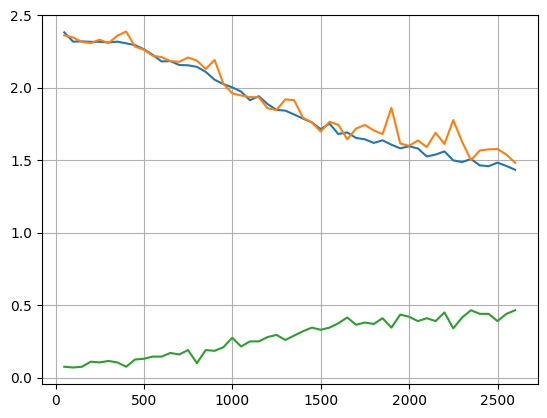

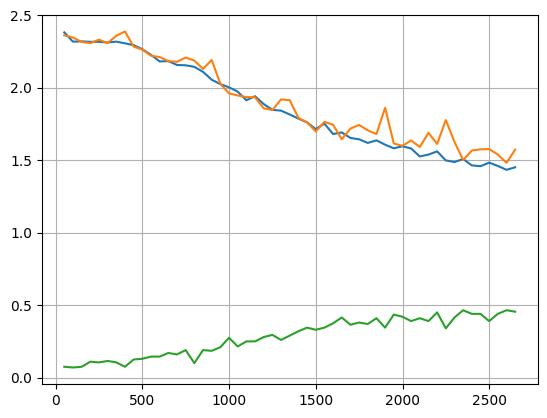

========== EPOCH 17 COMPLETED ==========


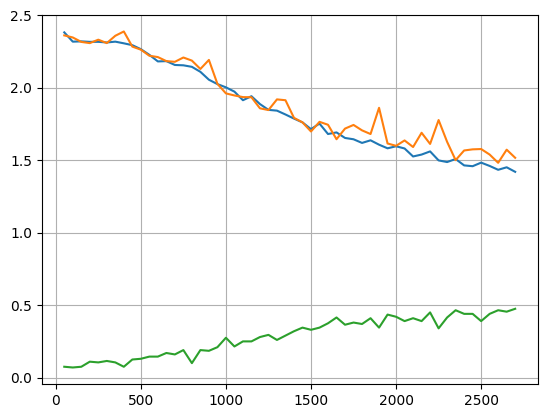

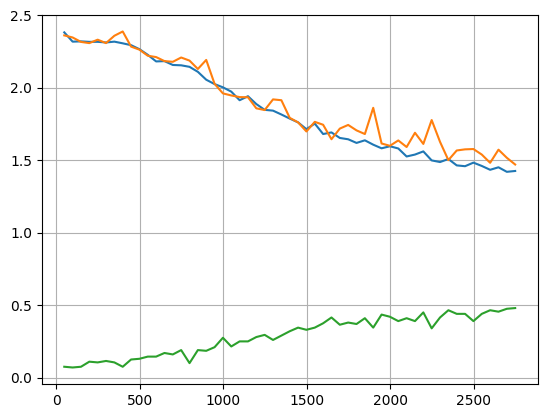

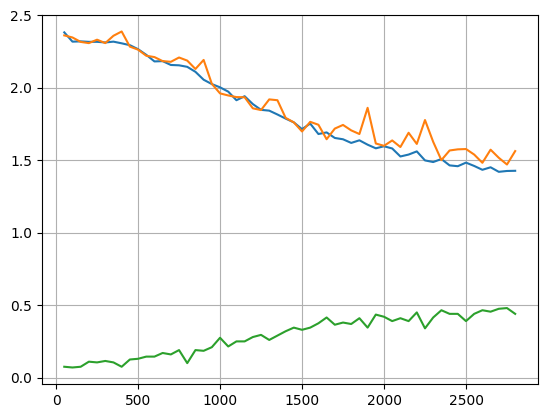

========== EPOCH 18 COMPLETED ==========


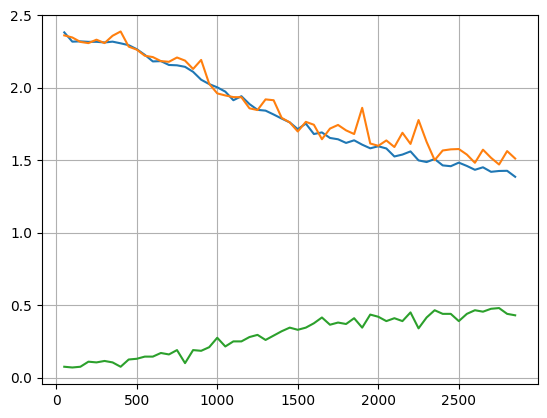

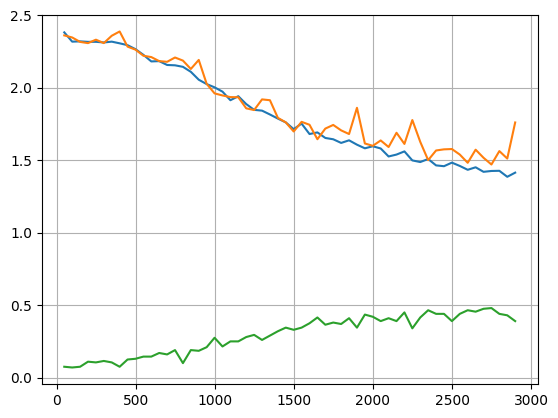

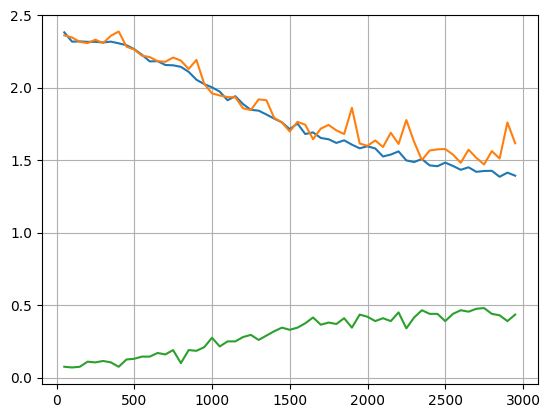

========== EPOCH 19 COMPLETED ==========


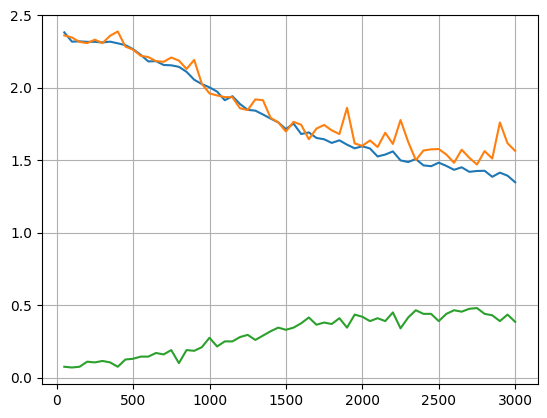

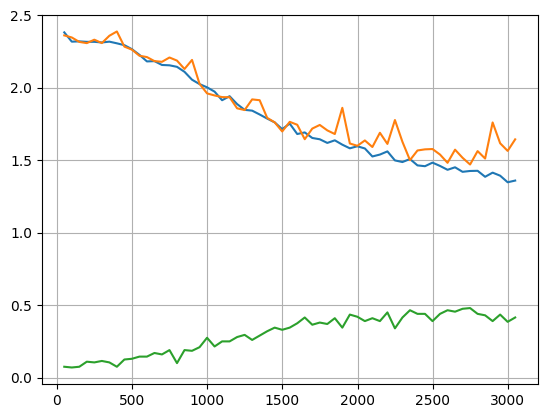

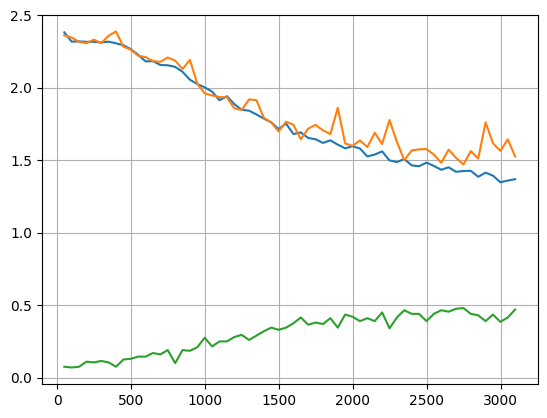

========== EPOCH 20 COMPLETED ==========


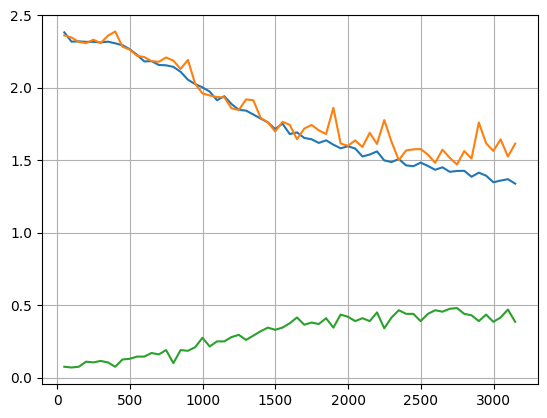

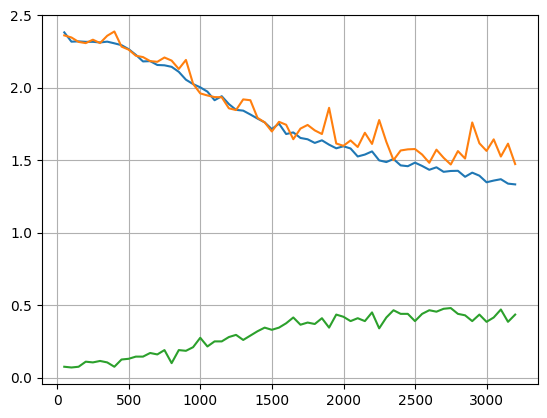

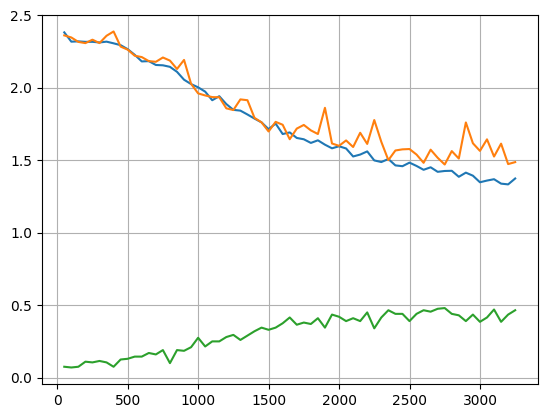

========== EPOCH 21 COMPLETED ==========


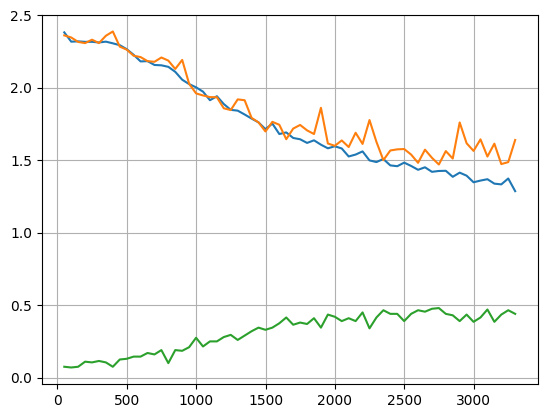

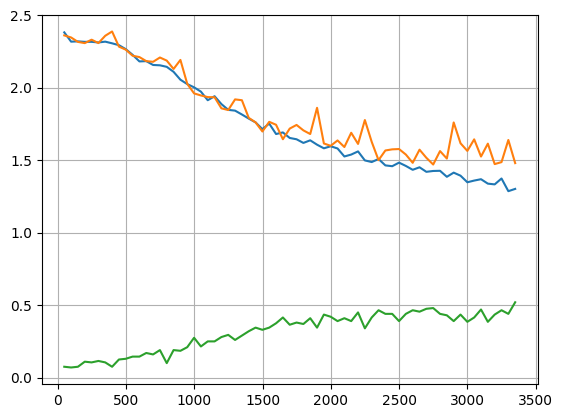

KeyboardInterrupt: 

In [21]:
losses = []
#slosses = []

for k in trange(999999):
    net.train()
    l = loss()
    #sl = sloss()
    l.backward()
    losses.append(l.item())
    #slosses.append(sl.item())
    net.optim.step()
    net.zero_grad()

    if len(losses) == 50:
        vl, vacc = valloss()
        net.vlosses.append((net.iters, vl))
        net.vaccs.append((net.iters, vacc))
        net.losses.append((net.iters, np.mean(losses)))
        #net.slosses.append((net.iters, np.mean(slosses)))
        losses = []
        #slosses = []

    if k % 50 == 0:
        plt.plot(*zip(*net.losses))
        plt.plot(*zip(*net.vlosses))
        plt.plot(*zip(*net.vaccs))
        #plt.plot(*zip(*net.slosses))
        plt.grid()
        plt.show()

    net.iters += 1

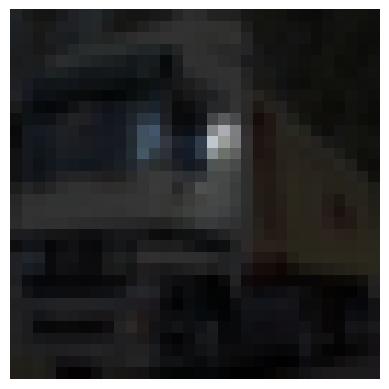

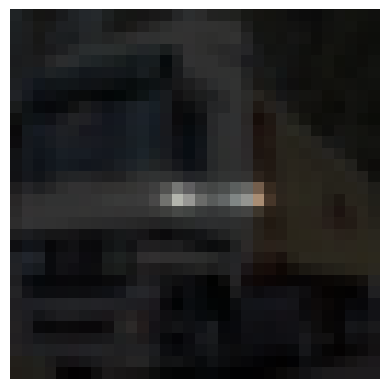

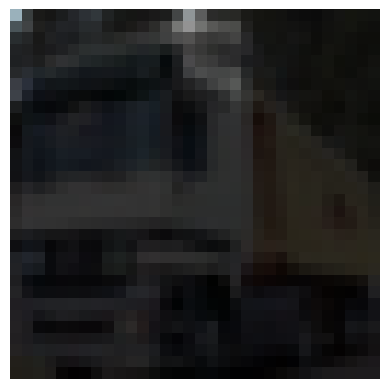

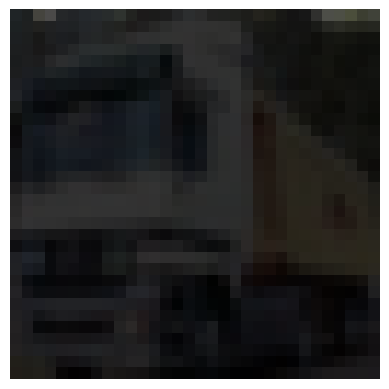

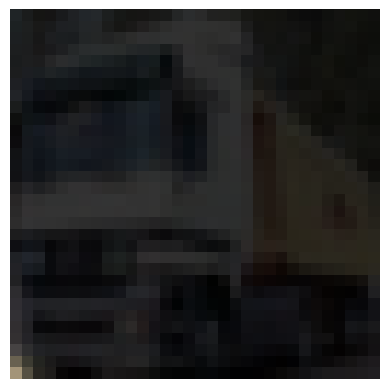

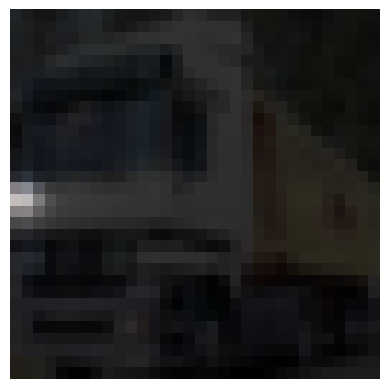

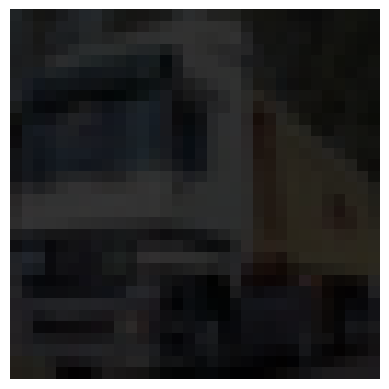

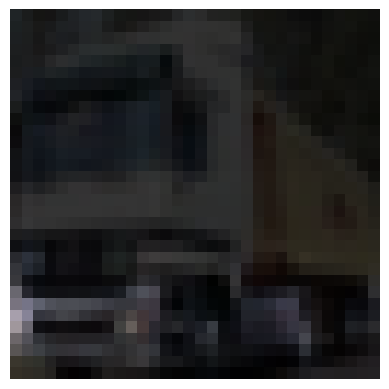

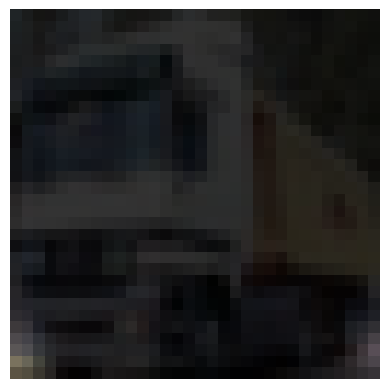

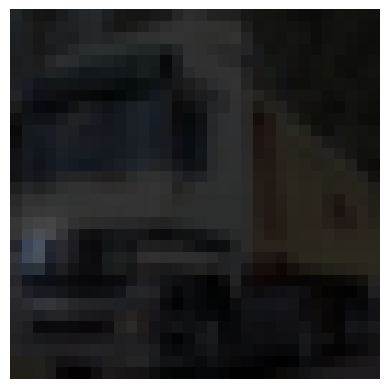

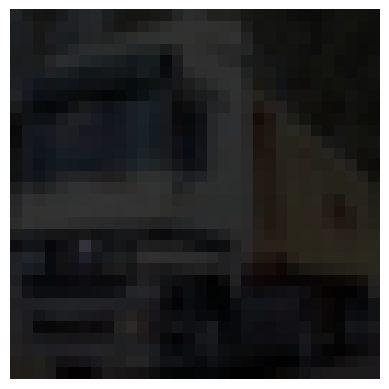

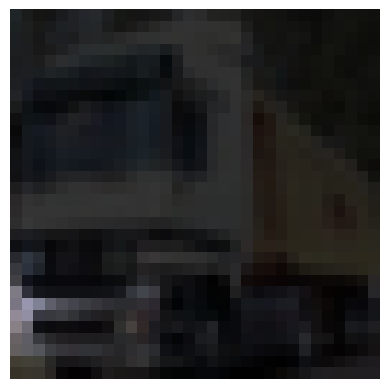

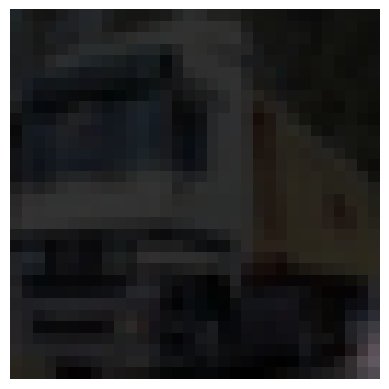

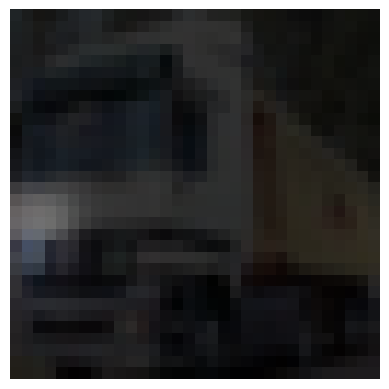

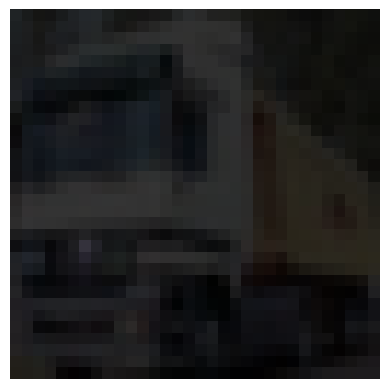

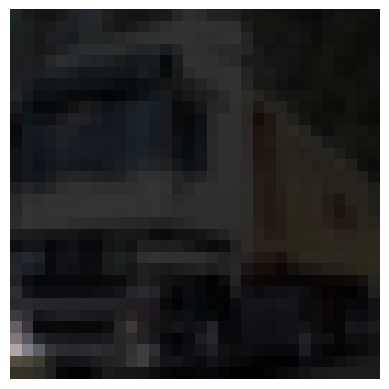

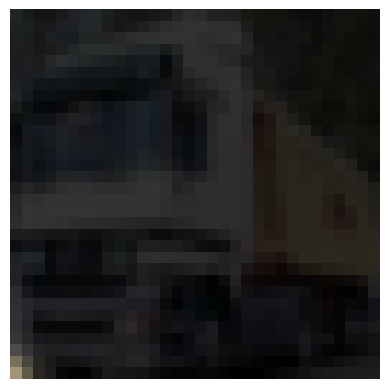

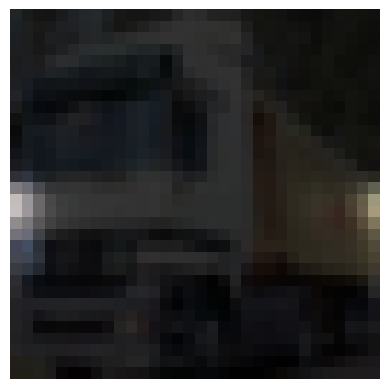

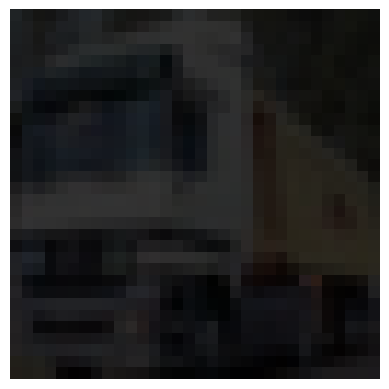

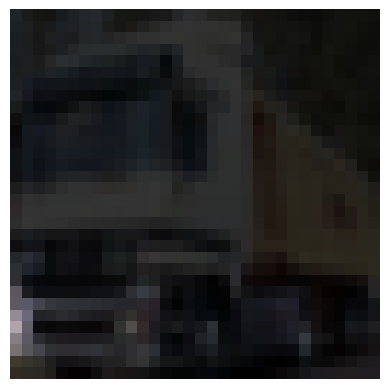

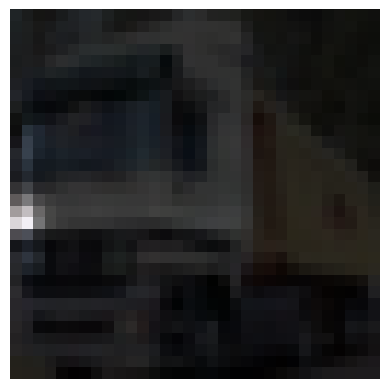

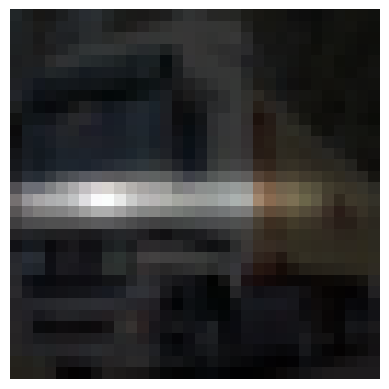

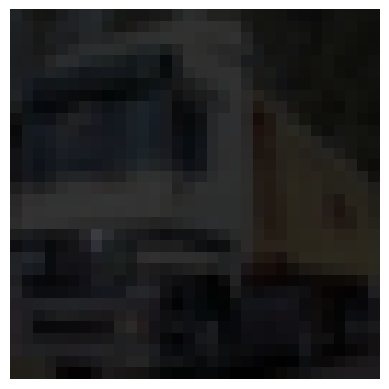

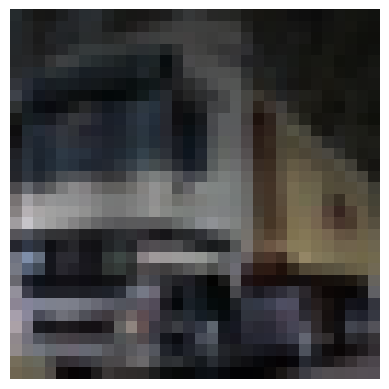

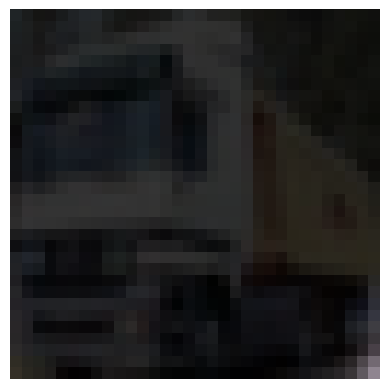

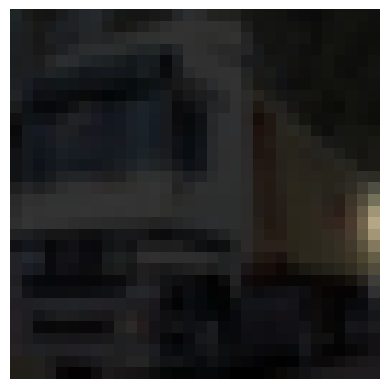

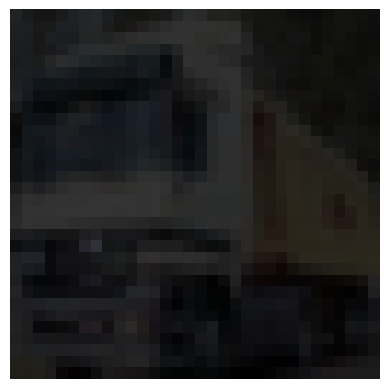

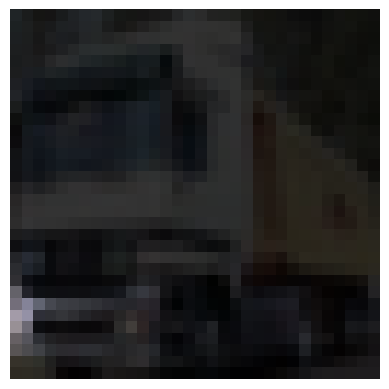

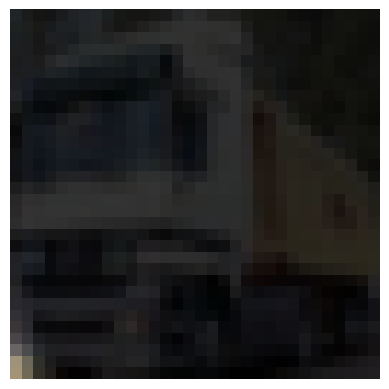

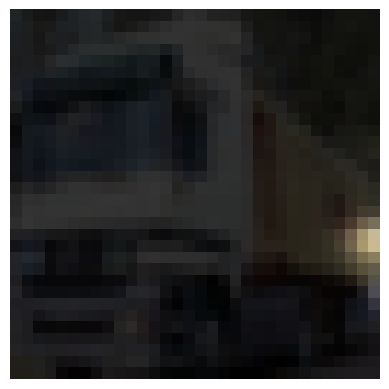

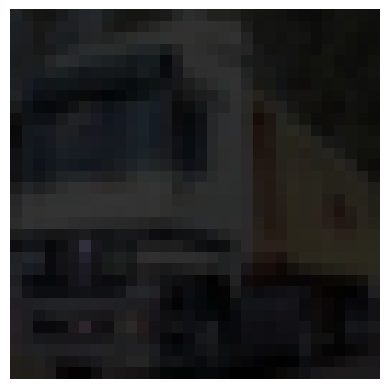

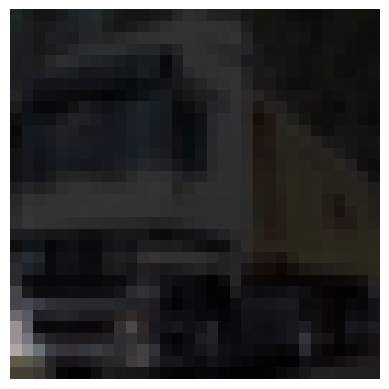

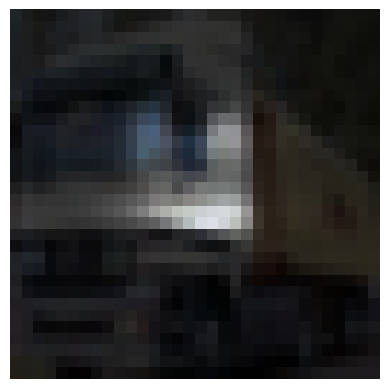

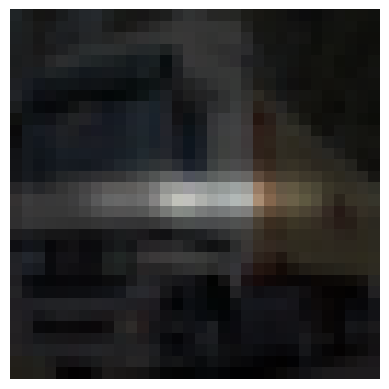

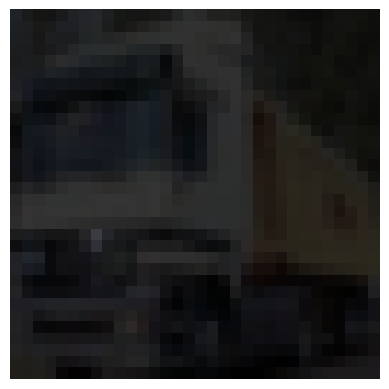

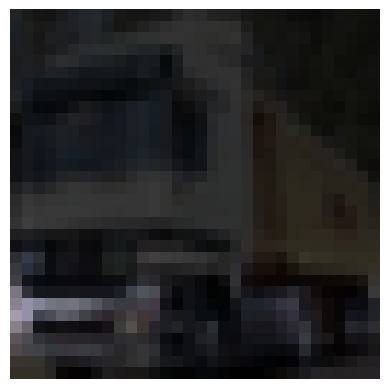

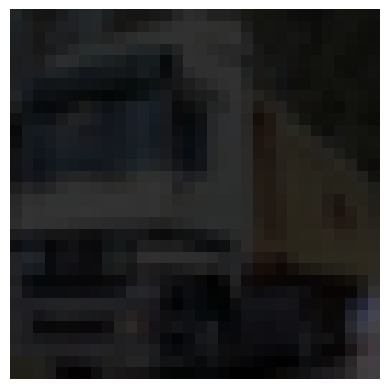

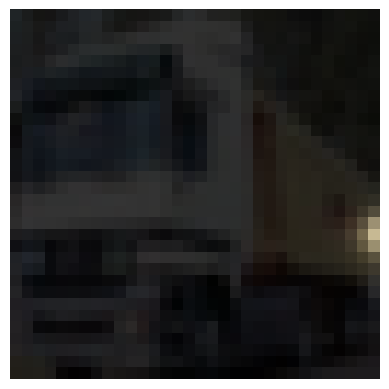

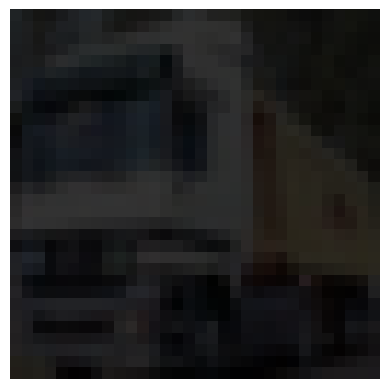

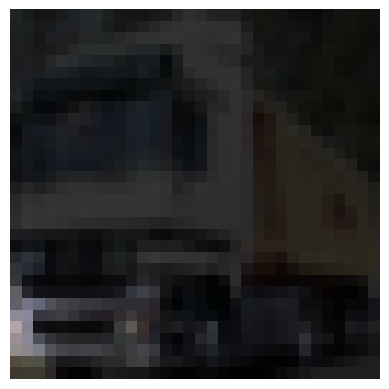

In [62]:
i = 1
net.eval()
x = getimg(i)
xs = np2t([x])
yp = net(xs)

for i in range(10):
    for j in range(4):
        beta = t2np(net.isab1.mab1.mha.beta)[0,j,i,:].reshape(32,32)
        showimg(x)
        plt.imshow(0*beta, alpha=.8-beta/beta.max()*.8, extent=(0, 1, 0, 1), cmap='gray')
        plt.show()